# Introduction
In this notebook, we will make a very simple pandas dataframe to benchmark BC and MMseq dataset for 3-fold cross validation. The dataframe is formatted to contain the following columns

* `3CVCrossFoldIndex` - Either 0,1 or 2 indicating the Testing fold in a 3-fold cross validation.
* `GenericFilename` - in the format of {pdbid}{conformationid} e.g. `2xs500000000`
* `Task` - Either AUCG or SXPR
* `SequenceHomology_ClusterType` - The sequence homology clustering algorithm. Either BC or Mmseq
* `SequenceHomology_Percent` - The sequence homology percentage. Either 30,40,50,60,70,90,95,100.
* `SequenceHomology_Clan` - The clan id as described in Notebook01
* `FilePath_HaloCoordinate`, `FilePath_ApoPdbCoordinate`, `FilePath_Label`, `FilePath_FeatureAltman` - File location of Apo sanitized structures, Class Labels, Altman feature, and Halos (coordinates with respect to the levitated surface above the protein)
* `Class_Name_%s`, `Class_HaloIndex_%s` - Indices to halo and corresponding class labels `%s`. The biological name of class labels e.g. A,U,C,G is stored in `Class_Name_%s`


These dataframes are stored in `DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, ClanGraphBcPercent)`. As an example,

* We will benchmark the trained NucleicNet using the dataframe. This will produce figures similar (almost exactly the same!) to `Notebook06`. 
* We will also use scipy SVM as an example of external program using the dataframe.


We understand our code is quite long. We hope this helps the reader by pulling out all the necessary codes from the very long `commandBenchmark` called in `Notebook06`.


In [1]:
# ============== Click Please.Imports
import sys
import glob
import gc
import io

import random
random.seed(42)
import pandas as pd
import numpy as np
import networkx as nx

from scipy import sparse
import torch
import seaborn as sns

import matplotlib.pyplot as plt


import time
import tqdm
import collections


import functools
import itertools
import multiprocessing



import torch 
from torch import nn

import torchvision as tv
import pytorch_lightning as pl


sys.path.append('../')
from NucleicNet.DatasetBuilding.util import *

from NucleicNet import Burn, Fuel
import NucleicNet.Burn.util
import NucleicNet.Burn.M1
import  NucleicNet.Burn.DA
%config InlineBackend.figure_format = 'svg'

sns.set_context("notebook")



# Turn on cuda optimizer
print(torch.backends.cudnn.is_available())
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
# disable debugs NOTE use only after debugging
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
# Disable gradient tracking
#torch.no_grad()
#torch.inference_mode()




True


# NOTE To be moved to 98.

In [2]:



# ================= Click Please. Directories ==================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000



PART00_CurrrentlyAvailPdbs = True
if PART00_CurrrentlyAvailPdbs:
    # ==================================
    # AUCG
    # ==================================
    Df_grand = pd.read_pickle(DIR_DerivedData + "/DataframeGrand.pkl")
    Df_grand = Df_grand.loc[(Df_grand["ProNu"] == "prot-nuc") & (Df_grand['Resolution'] <= 3.5) # NOTE you may consider to relax the 3.0 Angstron resolution limit as cryoEM structure w/ ~3.5 angstrom are not uncommon to be modelled in full atom these days
                                              & ~(Df_grand['PubmedID'].isnull()) # NOTE ~78 structures. Note that some are recent unindexed by pdb; most are unpublished structures. Some contains large missing loops.
                                              & (Df_grand['NucleicAcid'].isin(['rna']))
                                              & (pd.notnull(Df_grand['InternalSymmetryBC-95']))
                                              & (Df_grand["Year"] <= 2021)
                                              & (Df_grand["MeanChainLength_Nucleotide"] >= 4) & (Df_grand["SumChainLength_Peptide"] > 50) 
                                              # NOTE Some machineries that do not show preference in base or a disproportionately small amount of sites with preference.
                                              & ~(Df_grand["Title"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|rig-i|exosome|spliceosome|csy|csm|cas1|cas9|casc', regex=True, na=False)) 
                                              & ~(Df_grand["Header"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|rig-i|exosome|spliceosome|csy|csm|cas1|cas9|casc', regex=True, na=False))
    #                                          & ~(Df_grand["Title"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|exosome|spliceosome', regex=True, na=False)) 
    #                                          & ~(Df_grand["Header"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|exosome|spliceosome', regex=True, na=False))
                                              & ~(Df_grand['NpidbClassification'].isin(["TRANSFERASE/RNA",'TRANSFERASE','RIBOSOME'])) # ~170 structures

                                              # NOTE Author of paper indicate absence of sequence-specificity in article.
                                              & ~(Df_grand['Pdbid'].isin(['5o7h','7cyq',
                                                                          '5bud','5btb','5bte','5bto',
                                                                          '4b3g',
                                                                          '6vrb','6vrc',
                                                                          '2vnu', # NOTE contain selenomet MSE
                                                                          '7c08','7c07', # NOTE zinc cage interaction in zinc finger we cannot handle it
                                                                          '3hjw','3hjy','2bgg','1ytu',
                                                                          '4d26','4d25','5w3v','6vqv','4qik','4qil',
                                                                          '3t5n','3t5q',
                                                                          '6cbd','1knz','5id6',
                                                                          '2po0','2po1','2po2','2pnz',
                                                                          '4oo1','3m7n','3m85',
                                                                          '4tyy','4tz0','4tz6','4tyn','4tyw',
                                                                          '7bv2','7c42','7c43','7c45','7c47','7c4c','7c4b',
                                                                          '6zdp','6zd1','6zd2','6zd6','6zdq','6zdu',
                                                                          '4hor','4hoq','4hos','4hot','4hou',
                                                                          '6f3h','6w6v',
                                                                          '4p3e', '4p3f', '4p3g',
                                                                          '5jc3','5jc7','5jcf','5jch',
                                                                          '5c9h',
                                                                          '3wbm', # NOTE `Although these proteins are abundant and bind both DNA and RNA sequences nonspecifically`
                                                                          #'4z4c', '4z4d', '4z4e', '4z4f', '4z4g', '4z4h', '4z4i' , "appear non-specific" (??? Check)
                                                                          '6bjg', '6bjh', '6bjv', '1rpu',
                                                                          '5ws2','6llb',
                                                                          '6r7g',
                                                                          
                                                                          '5n8l', '5n8m', # NOTE `We find that siRNA recognition by the dsRBDs is not sequence-specific but rather depends on the RNA shape. The two dsRBDs can swap their binding sites, giving rise to two equally populated, pseudo-symmetrical complexes, showing that TRBP is not a primary sensor of siRNA asymmetry. `
                                                                          '6sjd', # NOTE This is a shape dependent selection where base marginally touch https://genome.cshlp.org/content/30/7/962.full.pdf+html
                                                                          '6bbo','6b0b', # NOTE `The human A3H-duplex RNA binding mechanism is mediated in large part by electrostatic contacts between the enzyme and the RNA phosphodiester backbone, as opposed to sequence-specific contacts. `
                                                                          '6vqw', '6vqx','6vqv', # NOTE Many Cas system does not have sequence preference such that the machinery is versatile. In this paper they demo Cas7f ` Cas7f and crRNA form multiple hydrogen bonds, which mostly occur between the arginine-rich region (F32, R34, R68, Q95, R168, Q247, Q276, K277, R283, S308, R350) and the sugar-phosphate backbone of crRNA, with only two nucleobases (G[+14], G[+19]) involved (SI Appendix, Fig. S7E). This finding indicates the nonsequence-specific crRNA recognition mode of Cas7f.`
                                                                          '3sn2','3snp', #NOTE `Given the similarities in the structures of the IRP1-bound TfR B and Ftn H IREs in this region, and the lack of sequence-specific contacts between IRP1 and the IRE upper helix, the impact of sequence differences in the upper helix on protein binding may relate to effects on helical twist and pitch, and/or to effects on helix stability.`
                                                                          #'6uv2','6uv3','6uv4', # NOTE The sequence specificty is debated and likely multilabel RCAYCH especially when a U10 can also bind 
                                                                          '2gtt','7acs','6yi3', # NOTE `Our model also explains the unspecific nature of N-NTD:RNA interaction. The N-NTD virtually only interacts with the RNA backbone while the bases are, in the case of ssRNA flipped away from the protein, or, in the case of dsRNA involved in base pairing but do not interact with the N-NTD `
                                                                          '2wj8', #NOTE `Although the N RNA contacts in the groove are not base-specific, the cavity appears tailored to bind a set of three stacked bases, a feature that appears to be conserved across the Mononegavirales order. Because the bases are averaged out in our crystals, it is not possible to tell from the structure whether certain particular nucleotide sequences would make stronger or weaker interactions within the cavity. `
                                                                          '2c0b', '2bx2', '2c4r', # NOTE `Aside from that contact, there is no sequence recognition as such, so it seems that the preference of RNase E for A + U-rich substrates27,28,29 arises mainly through the recognition of the RNA conformation.`
                                                                          '3l25','3l26', #NOTE `In the absence of base-specific contacts, it is likely that the interactions observed between the VP35 IID central basic patch and the 8-bp dsRNA are independent of the nucleotide sequence. `
                                                                          '4fvu', # NOTE ` By design, each individual strand of RNA is composed of either all-purine or all-pyrimidine bases. The single all-purine and all-pyrimidine strands were annealed to yield dsRNAs that each contain one all-purine and one all-pyrimidine strand. Digestion of dsRNA by Lassa NP is sequence-independent, and thus, there is equal likelihood for either the purine-containing or the pyrimidine-containing strand to be digested. `
                                                                          '3ks8','3ks4', # NOTE `This crystal structure shows that each VP35 in the dimer contacts the dsRNA exclusively through the sugar-phosphate backbone and hydrophobic faces of terminal bases, allowing the VP35 dimer to recognize dsRNA in a sequence-independent manner. `
                                                                          '2zko', # NOTE `NS1A RBD has the ability to distinguish between dsRNA and dsDNA and recognizes dsRNA in a sequence-independent manner because all the intermolecular contacts are directed towards the sugar-phosphate backbone and 2′-OH groups on the RNA strand`
                                                                          '6zlc', '6sx0','6sx2', # NOTE The title of the pdb says non-specific, but the article cited a few specific sequences at the tip of a hairpin not resolved.
                                                                          '4e78','4e7a','4e76', #NOTE `None of the nucleobase hydrogen bond acceptors or donors is recognized by the polymerase, indicating sequence-independent recognition by the polymerase. `
                                                                          '2ix1','2ix0', # NOTE `The final nucleotides 9–13 are located in a cavity within the RNB domain (Fig. 1c, d), with their five bases clamped between conserved Phe 358 and Tyr 253 (Fig. 2b and Supplementary Fig. S10). Each phosphate group is engaged in one or two hydrogen bonds with protein residues, a characteristic of non-sequence-specific nucleotide recognition sites.`
                                                                          '6aay', # NOTE `in order to verify whether A(-37) possesses the base specificity for the pre-crRNA cleavage, A(-37) was mutated to G, C and U, respectively. Results indicate that base type change at this position does not influence the cleavage activity, `
                                                                          '3pf4','3pf5', # NOTE `The similar kon values indicate low specificity of Bs-CspB association to all oligonucleotides examined regarding the base composition and the type of ribose rings,`
                                                                          '2i91','1yvp','1yvr', # NOTE 2i91 states that `the structure suggests that Ro recognizes helix I of the misfolded RNA as a duplex rather than recognizing any specific sequence.`
                                                                          '4oav','4oau', # NOTE Both are resolved with a polyA sequence, but author indicate specificity as recognizes the pattern UN^N. In this case, only the ribose and phosphate are good for use.
                                                                          '5z9x','5z9z', # NOTE `Unlike many RRMs, which exhibit strong substrate binding affinities (in the nM range) and sequence specificities, SDN1 RRM binds RNA weakly in a sequence independent mode. `
                                                                          '6htu','6sdy','6sdw', # NOTE `Human, Drosophila, and C. elegans Stau were in fact shown to bind dsRNA without apparent sequence specificity in vitro``
                                                                          '5y58','5y59','5y5a', # NOTE ` The base of A304 packs against the aliphatic loop L15-16 (between strands β15 and β16) of Ku70 and makes no sequence-specific hydrogen-bonding interactions with the protein (Figure 2F). Substitution of A304 with any other nucleotides had marginal effect on the interaction between Ku and TLC1KBS (Figures 2D and S2). `
                                                                          '5ns3','5ns4', # NOTE `Our crystallographic studies confirm the predisposition of Cy3 and Cy5 to stack on the final basepair of double-stranded nucleic acids. We have noted that this is true irrespective of the identity of the sequence of the terminal basepair` 
                                                                          '5ed2','5ed1','5hp2','5hp3', #NOTE `However, the observed clash is not severe, and the enzyme would be able to accommodate G or C 5′ nearest neighbors by slight structural perturbations, thus explaining why this sequence preference is not an absolute requirement.`
                                                                          '6o5f', # NOTE `We found no base-specific recognition of RNA by the protein`
                                                                          '7dic','7dcy','7dol','7did', # NOTE `All the samples tested effectively digested a 30-mer ssRNA in a sequence and length independent manner`
                                                                          '3rc8',# NOTE `bases are mutually stacked but they form only two hydrogenbonds with the surrounding protein residues. Generally, thesequence conservation of these motifs is lower than in theATP-binding motifs, but some characteristics are common tomost of the SF2 superfamily members.`
                                                                            # NOTE `Intriguingly, RIG-I is observed to bind all blunt RNA termini in much the same way, without regard to RNA sequence or the presence of a 5′-triphosphate`
                                                                          '4db2','4db4', # NOTE `No protein contacts are observed to the RNA bases of either strand (Fig. 3), consistent with the non-specific RNA binding shown by Mss116p and other DEAD-box proteins1. `
                                                                          '7k9e','7k9d','7k9b','7k9c','7kkv', #NOTE `The lack of base-specific interactions, except for the two hydrogen bonds mediated by the first G501 in the tetraloop (Fig. 3B), indicates that the specificity of OapB binding to this region is dictated by the tertiary conformation of the GNRA tetraloop, rather than exact sequence within this tetraloop family.`
                                                                          '4ijs','3zla','3zl9', # NOTE from 3zla paper `previous studies have shown that RNA bound to purified soluble recombinant tetramers contains no specific or consensus sequences `
                                                                          '7onb', # NOTE The MINX is unmodeled 

                                                                          '6u6y', # NOTE 4-nt long sequence but only one base is modeled for 3 out of 4 chains; one chain with 3 base but only one in contact.,...
                                                                          '5ddo','5ddp','5ddr', '5ddq', # NOTE Riboswitch
                                                                          '6e4p', # NOTE polyu `ur FP studies revealed that the RRM domain binds with high affinity to U20 and G20 RNA. Interestingly, however, the RRM bound with significantly higher affinity to poly(G) sequences than poly(U) RNA (Supplemental Figure S2; Figure 5A). These data and the fact that the RRM-U4 structure revealed what appeared to be specific interactions between the protein backbone and the uridine bases, suggested that the RRM might bind poly(G) in a manner distinct from poly(U). `
                                                                          '7elc', '7ela', '7elb','7el9', # NOTE This is a polymerase structure, there is no mention of base specific interaction in article https://www.nature.com/articles/s41564-021-00916-w
                                                                          '5jrc','5jre','5jr9', # NOTE `Among the nucleic acid interacting residues, mutations of Lys19 had no obvious impact on the cleavage activity of the protein (K19A). However, alanine substitutions of Ser26 and Arg164 all led to weakened cleavage activities of the mutant proteins (S26A and R164A), compared with the WT. Mutations of other residues, including Lys34, Arg124, Arg163 and Tyr168, caused more significant reduction on the cleavage activities of the mutants (K34A, R124A, R163A and Y168A). These results were all consistent with the structural observations.Interestingly, the in vitro cleavage assays with both substrates showed an obvious pattern of products. Comparison with the FAM-labeled markers, including (AC)5 and (AC)5A in Figure 4A, and (GT)5 and (GT)5G in Figure 4B, indicated that NeC3PO preferentially cut after the purine residues. In the NeC3PO:ssRNA structure, the side chain of Phe160 stacked with the nucleobase of A6 (or A6′). Replacing Phe160 with residues that has larger (Trp160 for F160W) or smaller (Ala160 for F160A) side chains showed certain enhancing or weakening effect on the overall cleavage activity of the mutant proteins, compared with the WT. However, the mutant proteins still selectively cut after the purine residues. These observations indicated that Phe160 plays important role in the substrate binding, but is not the main cause of NeC3PO preference to purine.`
                                                                          '6wxx','6wxy','6xl1','6wxw','6sce', # NOTE requires short cyclic nucleotide cA4 for specificity 
                                                                          '3trz', '5udz', '3ts0', # NOTE Part of the recognition unit contains zinc cage
                                                                          '6fqr', # NOTE This structure is with CCCC 6gx6 with ACAC `IMP3 RRM12 bound to CCCC and AAAA with similar, but, weak affinity (∼40 µM) (Fig. 2A,B,D). We did not detect the binding, however, to either UUUU or GGGG indicating modest sequence specificity (Supplemental Fig. S4B,C). IMP3 RRM12 bound to ACAC with almost an order of magnitude higher affinity (∼5 µM) indicating its preference for this dinucleotide sequence (Fig. 2C,D).`
                                                                          '6sy4', '6sy6', # NOTE This is a very interesting pair. The RNA bound is asymetric but the protein is symetric such that some interactions at Q38 for guanosine is lost `Due to the asymmetric nature of the interface, Arg28′ and Gln38′ from the second protomer neither participate in cation-π interactions (Arg28′) nor in guanine recognition (Gln38′).`
                                                                          '7om7','7oma','7om6','7om2','7om9', # NOTE These are dsRNA structure w/o contact with base. The paper does not mention base interaction/specificity either https://www.mdpi.com/1999-4915/13/7/1260/html

                                                                          '5udk','5udi','5udj','5udl', # NOTE ` IFIT1 forms a water-filled, positively charged RNA-binding tunnel with a separate hydrophobic extension that unexpectedly engages the cap in multiple conformations (syn and anti) giving rise to a relatively plastic and nonspecific mode of binding, in stark contrast to eIF4E. `
                                                                          '5oc6', # NOTE `This domain, typically ∼68 amino acids, is well-known for its functional versatility by means of a particular α1-β1β2β3-α2 canonical structure that allows it to recognize a variety of simple RNA structures ranging from A-form RNA helices to hairpins or tetraloops in shape-dependent manners (7,9,10), even though a sequence-specific mode of recognition has been invoked for a few of them (11,12).`
                                                                          '3qsu', # NOTE This is the poly A structure `Binding studies show that Sa Hfq binds (AU) 3 A ≈ (AG) 3 A ≥ (AC) 3 A > (AA) 3 A `
                                                                          '1ddl', # NOTE `With both fragments of RNA, binding to protein through hydrogen bonds to either phosphate or ribose groups of the RNA appears not to be sequence-specific. The density seen for base rings fails to suggest any specific nucleotide sequence. `
                                                                          '6nut', # NOTE ` We modeled this density as a polymer of six adenosine residues since, as expected, none of these resi-dues makes sequence-specific contacts`
                                                                          '3nmr','3nna','3nnc', # NOTE These are selenomethionine substituted structure. 3nnc and 3nnh are not! but 3nnc contains a pseduo symmetric unit with without bound rna `The structures of RRM1/2 in complexes 1 and 2 were determined by multiwavelength anomalous dispersion (MAD) phasing on Se atoms using selenomethionine-labeled protein. The structure of complex 3 was solved by molecular replacement using the refined structure of complex 1 determined at 1.85 Å resolution, as a search model (`
                                                                          '4yhw', # NOTE Structure contains a selenomethionine at multiple position eg 417, we cannot handle it `yU4/U6stem II+10nt was slowly added to the SeMet-substituted yPrp3CTF in a 1:1 molar ratio and incubated at 4°C for 15 min. `
                                                                          '6uv2', '6uv3', # NOTE “VCAUCH” (Mori et al., 2014) to “RCAYCH.” These two specificities are contested and this paper prefers the latter. I removed the CACACA and ACACCU which contradict Mori et al
                                                                          '5d0b','5d0a','5d08', '5t8y' , # NOTE Interactions with base are not found by pymol standard
                                                                          '5gjb', # NOTE `he ribose group of ATP bulges out from the binding pocket and no clear electron densities are observed for the adenine group, suggesting that the ZIKV helicase may not have nucleotide specificity for its NTPase activity.`
                                                                          '5uz9', # NOTE Largely non-specific `crRNA binding by Cas7f is mediated by non-sequence specific contacts between the sugar-phosphate backbone and residues on the palm (R35, H275, Q277, K278, N281, R284) and web (R169, Q248). `
                                                                          '4oq8', '4oq9', '4nia', # NOTE The authors attempted different constraints/restraints to refine a X-ray data, but the single potential base interaction is very marginal  ` It can now be seenthat the base is stacked upon the guanidinium group ofArg125. In addition, the side chain of Asn16 is nearly coplanarwith and approaches the edge of the base, where it could beoriented to form hydrogen bonds with appropriate atoms onthe nucleotide base. The latter feature, as proposed by Seemanet  al.(1976), could thereby provide some degree of basespecificity at the ‘free nucleotide’ position.` 
                                                                          '1bmv', # NOTE `Interactions with protein are dominated by nonbonding forces with few specific contacts. ` viral cap
                                                                          '2jlq', '2jlr', '2jls', '2jlu', '2jlv', '2jlw', '2jlx', '2jly', '2jlz',  # NOTE `As expected, RNA recognition appears to largely occur in a sequence-independent manner as a 13-mer oligoribonucleotide (RNA13) having a different sequence binds to NS3h in essentially the same way as the 12-mer oligoribonucleotide`
                                                                          '5ytx','5yts', # NOTE These are solved with suboptimal sequence against sibling at 5ytt, 5ytv`ater, using the iCLIP-Seq method, we mapped the in vivo YB-1–binding sites at a genome-wide level and found that YB-1 preferentially recognizes a UYAUC motif, which closely resembles the binding motif determined by in vitro SELEX (38). In a recent study, the CAUC motif was also identified as a YB-1–binding motif in a fused cell line by `
                                                                          '3o3i', # NOTE Only backbone interaction is reported https://www.pnas.org/doi/full/10.1073/pnas.1017762108
                                                                          '1gtn', '1gtf', # NOTE the sequence with CC spacer is less tightly held `. In the  complex with CCspacers, where the spacer region is least ordered, the G1 baseis 0.5 Afurther  from  the  protein  than  in  the  other  twostructures. In both the complex with GAGUU and that withGAGCC,  the  second  of  the  two  spacer  nucleotides  is  lessordered than the Ærst.`
                                                                          '6muu', # NOTE `The absence of base-specific contacts between protein residues and bases of the crRNA within the 5+1 repeat accounts for the lack of sequence specificity for spacer sequence recognition.`
                                                                          '5jji','5jjl','5jjk', # NOTE These set of protein does not interact with the base as the  author argue that the specificty for pyrimidine is induced allosterically 
                                                                          '7ogk', # NOTE Also note that base are not resolved. `A degenerate ARN-repeat sequence in the RNA substrate interacts with one of the Hfq RNA-binding surfaces, bridging Hfq and PNPase, and indicating a loose sequence preference for carrier assembly. `
                                                                          '2izm', # NOTE This structure is resolved with C-10 but G-10 or A-10 is preferred see 2izn ` The –10 base (the bulge) and the –4 base (in the loop) bind similar pockets in the two halves of a dimer, making extensive contacts through hydrogen bonding and hydrophobic interactions ( 5 ). Only an adenosine can be accommodated at the –4 position without a significant reduction of binding ( 7 ). The wild-type TR sequence has an adenosine at position –10, but binding studies have shown that guanosine gives a similar binding constant to adenosine, if the sequence in the stem is changed so that alternative conformations are avoided `
                                                                          '5z9w', # NOTE ` Our structure reveals how the Ebola virus nucleocapsid core encapsidates its viral genome, its sequence-independent coordination with RNA by nucleoprotein, and the dynamic transition between the RNA-free and RNA-bound states.`
                                                                          '6r9q','6r9p','6r9m','6r9j', '6r9o' # NOTE Not by touch`Crystal structures of Saccharomyces cerevisiae Pan2 in complex with RNA show that, surprisingly, Pan2 does not form canonical base-specific contacts. Instead, it recognizes the intrinsic stacked, helical conformation of poly(A) RNA. `
                                                                          ]))
                                              # NOTE Unpublished but with pubmedid?
                                              & ~(Df_grand['Pdbid'].isin(['3p6y', '2n8m', '3ahu']))
                                              # NOTE Cases where metal/interfacial inhibitor/tip of hairpin/water-mediated/marginally/modified base interacts with rna base
                                              & ~(Df_grand['Pdbid'].isin([  
                                                                            '2lsl',
                                                                            
                                                                            '5zc9', # NOTE eIF4A1 chemical clamp, water
                                                                            '6xki', # NOTE eIF4A1 chemical clamp, water
                                                                            
                                                                            '4bkk', # NOTE nucleoprotein. There is no mention of base interaction through out the article https://www.microbiologyresearch.org/content/journal/jgv/10.1099/vir.0.053025-0
                                                                            '6yrb','6yrq', # NOTE No base interaction mentioned in paper (Check again)
                                                                            '1yyw', '2nug', '2nue', '1yz9',# NOTE These is a AU dsRna but prefer GU in other Rnase3 at Q157, 1yz9 makes no contact w/ base
                                                                            #'2bs0', # NOTE RNA at interface of two varial capsid protein symmetry mates
                                                                            '7n0c','7n0b','7n0d', # NOTE exoribonuclease proof-reading complex but when mismatch the base makes no touch
                                                                            '2xgj', # NOTE Helicase w/ no touch at base



                                                                            # NOTE Structure solved with Poly-Oligonucleotiude just as a template
                                                                            '5wwf', '5ho4', # NOTE These are proteins resolved with same interacting sequence. Its siblings 5wwg 5wwe 5wwx makes most contact with the protein
                                                                            '4ht8', '3gib', # NOTE 4ht9 has a higher resolution also with additional uridine sites shown
                                                                            '4ijs', # NOTE They use a polyA sequence for simplicity. even though there are interaction with some of the bases.
                                                                            '2xbm', # NOTE specificity is in a dinucleotide labeled as G3A
                                                                            
                                                                            '5eeu', '5eev', '5eew', '5eex', '5eey', '5eez', '5ef0', '5ef1', '5ef2', '5ef3', '1utd', '4v4f', # NOTE While the protein is the same, RNA does not show up in a pseudo symmetry mate. Half and Half. also note a lot of unmodeled nt https://www.rcsb.org/3d-view/5EEV/1
                                                                            '6dtd', #  NOTE Cas 13b
                                                                            '2zi0', '4erd', # NOTE single helix contact
                                                                            '6cf2', # NOTE single helix contact

                                                                            #'6mdz', # TODO Ttesting
                                                                            '5js2', '5ki6', # NOTE Modified base argonaut
                                                                            '6oon','5vm9','5w6v','4kre','4kxt','4olb','4ola', # NOTE Poly-A sequence bound to argonaut
                                                                            '5t7b' # NOTE unpublished argonaut
                                                                            '4z4c', '4z4d', '4z4e', '4z4f', '4z4g', '4z4h', '4z4i', # NOTE This series of pdbid concerns a water mediated recognition site for adenosine on argonaute `Water-mediated recognition of t1-adenosine anchors Argonaute2 to microRNA targets`
                                                                            '5js1', '4w5o', '4w5q', # NOTE Argonaut structure. 4w5o,q has more missing residue than siblings 4w5t,r,n.
                                                                            '5wqe', # NOTE multiplebase specific interactions were outlined but most interacts with peptide backbone.
                                                                            '5wtk', # NOTE 4 base specific interactions were outlined but the structure is ds and some sidechains e.g. 415-416 were stubbed. we will not include it in training

                                                                            # NOTE No specific H bond contact found/does not fulfill Hbond criterion in pymol
                                                                            '5ztm', # NOTE The claimed interaction at E172, N175, Q195 does not fulfill H-bond criterion in pymol. Find>Polar Contacts
                                                                            '6h5s','6h5q', # NOTE no specific H bond  contact
                                                                            '4al7','4al5','4al6', # NOTE base binding site at an unmodeled loop
                                                                            '4n2s','4n2q','4me2', # NOTE close but no defined H bond 
                                                                            '6hyu', '6hyt', # NOTE polyA used and no Hbond specific contact
                                                                            


                                                                            '5t8y', 

                                                                            '4z92', # NOTE minimal contact in vriys 
                                                                            '3hsb', # NOTE a AGAGAG aptamer used but the G does not form specific hbond interactions 
                                                                            '7bg6','7bg7','7nuq','7nun','7nuo','7nul','7num', # NOTE only stack touched
                                                                            '5f9f', '5f98','5f9h','5e3h','3eqt', # NOTE RIG-I recognise modified base m7G `https://www.pnas.org/doi/full/10.1073/pnas.1515152113`
                                                                            '5z98','4lg2', # NOTE duplex
                                                                            '2ihx', # NOTE Disordered
                                                                            '4gv3','4gv6','4gv9','4gve','4g9z', #NOTE backbone only
                                                                            '7c06', # NOTE it shares same sequence ith 7c08 but poor?
                                                                            
                                                                            '3ciy' # NOTE dsRNA
                                                                            '5jbg', # NOTE MDA5
                                                                            '4ill', '4ilm', '4ilr', # NOTE The RNA strand appears broken??? (bonds too long)
                                                                            '6s8b','6s8e','6shb','6sic','6s91','6s6b', # NOTE Backbone only. marginal interaction

                                                                            '4peh','4peg','4pei','4pef', # NOTE modified base

                                                                            '5jaj','5jb2','5jbg', # NOTE LGP2 duplex
                                                                            '4lg2', # NOTE duplex
                                                                            '4gha','5m73', # NOTE dsrna

                                                                            '3ciy', # NOTE 3.41 angstrom resolution, some sidechain can be highly flexible
                                                                            
                                                                            

                                                                            '3zd6','3zd7', # NOTE Rig I

                                                                            '3zc0', # NOTE almost no contact
                                                                            '2jlw', # NOTE no contact
                                                                            '6ozp', '6ozn', '6ozf','6oze', '6ozg', '6ozh','6ozi', '6ozj', '6ozk', '6ozl', '6ozm',  '6ozo',  '6ozq', 
                                                                            '6ozr','6ozs', # NOTE through backbone
                                                                            '2gje', # NOTE backbone only
                                                                            '1f8v', '2bbv', # NOTE backbone only duplex cage in virus capsid

                                                                            
                                                                            '2mxy', # NOTE solution structure with extra nucleotide compare to 2mz1
                                                                          

                                                                            '3pkm', # NOTE missing loop

                                                                            
                                                                            
                                                                            '2bx2', # NOTE Marginal

                                                                            '6d06', # NOTE modified base dsrna
                                                                            '3dh3', # NOTE Modified base
                                                                            '7kfn', # NOTE Modified base
                                                                            '4i67', # NOTE Modified nt
                                                                            '1jbt','1jbs','1jbr',
                                                                            '6gc5', #NOTE short strand
                                                                            

                                                                            
                                                                            '5uj2', # NOTE marginal; same family as 4e78

                                                                            '7ndh', '7ndi', '7ndj', '7ndk','3d2s', # NOTE require zinc cage
                                                                            '6l1w', '1rgo', # NOTE zinc finger    
                                                                            '4lj0', '5elk',# NOTE Zn finger short peptide

                                                                            '2mqv','2mqt','2ms0','2ms1','2mkn','5u9b','1wwe','1wwf','1wwd','1wwg','2n82','5u9b','1fje','1t4l',
                                                                            '2l3c','2lup','1a1t','2mf1','2mf0','1f6u','1ekz','6gbm','2mfe', '2mfg', '2mfh','2mff', '4cio','2jpp',#NOTE Disordered NMR solution structures
                                                                            
                                                                            '5c0y','5v7c', # NOTE no contact
                                                                            '5wea', # NOTE poly A sequence

                                                                            '6vff', # NOTE dsrna
                                                                            '7krn', '7kro','7krp', # NOTE Helicase dsrna
                                                                            '4pmi', # NOTE single helix


                                                                            # NOTE Water-mediated or simply in an envelope of water
                                                                            '4qoz', '4tuw','4tux','4tv0','4l8r', # NOTE water duplex
                                                                            '4mdx', # NOTE water
                                                                            '5l2l', # NOTE water
                                                                            '5elh', # NOTE water; 5elk has much tighter contact 
                                                                            '2pjp', '6lt7','6db8','6db9','1c9s','6c6k', '3ts2','5tf6',
                                                                            '4n0t','4kzd','6b3k','5e08','5h1l', '1m5o', '6fq3',
                                                                            '5gxh','4q9q', '6mwn','5det','6u8d','6u8k', '5gxi','6hau','6d12',
                                                                            '2y8y','2y9h','2y8w','4qvc','4f02','6fql','6fq3', # NOTE water
                                                                            ]))
                                              # NOTE Recently indexed shape-dependent machinery (tRNA/exosome/ribosome), but pdb has not updated its derived data
                                              & ~(Df_grand['Pdbid'].isin(['5hr7','5omw','5jea',
                                                                          '4o26', # NOTE telomerase
                                                                          '5fmz','5epi', # NOTE polymerase
                                                                          '6zoj', '6zok', '6zol', # NOTE Ribosome
                                                                          '6yan','6yam','6yal', # NOTE ribosome
                                                                          '5iwa', # NOTE ribosome
                                                                          '5e6m', # NOTE trna
                                                                          '5on2','5onh','5on3','5omw','3al0', '3akz', '5e6m', # NOTE tRNA 
                                                                          '1zl3', # NOTE trna specificity at modified base FLO
                                                                          '5ud5','5v6x','4qei','4kqe' # NOTE trna
                                                                          '3jam','3jap','3jaq', # NOTE This is a ribosome
                                                                          '5ng6', # NOTE Crispr machinery recognise DNA motif TTN but no mention of RNA
                                                                          '6sh8','6s6b', '6s8b', '6s8e', '6s91', '6shb', '6sic', # NOTE Crispr machinery no mention of base interaction
                                                                        ]))


                                              # NOTE 
                                                  ]
    #print(pd.unique(Df_grand['NucleicAcid']))
    print(Df_grand.shape)
    # NOTE Further Remarks on some interesting cases
    # 3PTO, 3PTX, 3PU0, 3PU1, 3PU4. uses the same nucleocapsid to bind with poly(A,U,C,G), which they use to test how interaction with each kind of base will look like and they propose UAG as an interesting motif to look for https://journals.asm.org/doi/10.1128/JVI.01927-10
    #                               polyG shows largest amount of interaction polyU shows none However at 3.0 Angstrom, the assignment of N161 can be flipped to make interaction with U27 (seem to support by K164)
    # 6O1K, 6O1L, 6O1M              `Hfq thus has a structural preference for (ARN)n RNA stretches on its distal side, where N is any nucleotide. `


    NmrStates_AUCG = [ '1aud00000004','1aud00000010','1aud00000002',
                  '2l4100000005','2l4100000011','2l4100000013',
                  '2xc700000000','2xc700000002','2xc700000006',
                  '1dz500000007','1dz500000008','1dz500000002',
                  '1k1g00000001','1k1g00000005','1k1g00000007',
                  '2ad900000017','2ad900000012','2ad900000019',
                  '2adb00000004','2adb00000005','2adb00000014',
                  '2adc00000007','2adc00000001','2adc00000000',
                  '2c0600000002','2c0600000004','2c0600000009',
                  '2cjk00000007','2cjk00000008','2cjk00000012',
                  '2err00000003','2err00000016','2err00000006',
                  '2fy100000008','2fy100000002','2fy100000000',
                  '2kfy00000006','2kfy00000003','2kfy00000001',
                  '2kg000000019','2kg000000012','2kg000000000',
                  '2kg100000006','2kg100000005','2kg100000003',
                  '2kh900000007','2kh900000001','2kh900000005',
                  '2km800000004','2km800000007','2km800000006',
                  '2kxn00000007','2kxn00000008','2kxn00000001',
                  '2l2k00000006','2l2k00000002','2l2k00000007',
                  '2l3j00000008','2l3j00000001','2l3j00000002',
                  '2l5d00000004','2l5d00000016','2l5d00000008',
                  '2lbs00000013','2lbs00000009','2lbs00000005',
                  '2leb00000018','2leb00000000','2leb00000016',
                  '2lec00000018','2lec00000002','2lec00000007',
                  '2m8d00000013','2m8d00000003','2m8d00000010',
                  '2mb000000004','2mb000000018','2mb000000001',
                  '2mfc00000005','2mfc00000001','2mfc00000015',
                  '2mfe00000001','2mfe00000002','2mfe00000013',
                  '2mgz00000017','2mgz00000004','2mgz00000009',
                  '2mjh00000019','2mjh00000006','2mjh00000009',
                  '2mki00000005','2mki00000014','2mki00000002',
                  '2mkk00000006','2mkk00000008','2mkk00000004',
                  '2mz100000018','2mz100000004','2mz100000003',
                  '2n7c00000002','2n7c00000010','2n7c00000007',
                  '2n8l00000003','2n8l00000006','2n8l00000004',
                  '2rra00000005','2rra00000008','2rra00000009',
                  '2rs200000018','2rs200000004','2rs200000017',
                  '2ru300000015','2ru300000011','2ru300000018',
                  '4cio00000000','4cio00000006','4cio00000008',
                  '5m8i00000008','5m8i00000014','5m8i00000006',
                  '5mpg00000011','5mpg00000007','5mpg00000003',
                  '5mpl00000004','5mpl00000012','5mpl00000002',
                  '5n8l00000014','5n8l00000018','5n8l00000013',
                  '5n8m00000015','5n8m00000004','5n8m00000002',
                  '5x3z00000016','5x3z00000010','5x3z00000001',
                  '6gbm00000002','6gbm00000000','6gbm00000011',
                  '6hpj00000013','6hpj00000006','6hpj00000012',
                  '6snj00000009','6snj00000000','6snj00000002',
                  '6tph00000004','6tph00000009','6tph00000001',
                  '7act00000009','7act00000008','7act00000000',
    ]

    Df_grand_AUCG = Df_grand
    del Df_grand
    gc.collect()
    # =========================
    # SXPR
    # =========================

    # TODO For SXPR the selection of pdb has to be separated less stringent than AUCG

    Df_grand = pd.read_pickle(DIR_DerivedData + "/DataframeGrand.pkl")
    Df_grand = Df_grand.loc[(Df_grand["ProNu"] == "prot-nuc") & (Df_grand['Resolution'] <= 3.5) # NOTE you may consider to relax the 3.0 Angstron resolution limit as cryoEM structure w/ ~3.5 angstrom are not uncommon to be modelled in full atom these days
                                              & ~(Df_grand['PubmedID'].isnull()) # NOTE ~78 structures. Note that some are recent unindexed by pdb; most are unpublished structures. Some contains large missing loops.
                                              & (Df_grand['NucleicAcid'].isin(['rna']))
                                              & (pd.notnull(Df_grand['InternalSymmetryBC-95']))
                                              & (Df_grand["Year"] <= 2021)
                                              & (Df_grand["MeanChainLength_Nucleotide"] >= 4) & (Df_grand["SumChainLength_Peptide"] > 50) 
                                              # NOTE Some machineries that do not show preference in base or a disproportionately small amount of sites with preference.
                                              & ~(Df_grand["Title"].str.contains('ribos|trna', regex=True, na=False)) 
                                              & ~(Df_grand["Header"].str.contains('ribos|trna', regex=True, na=False))
    #                                          & ~(Df_grand["Title"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|exosome|spliceosome', regex=True, na=False)) 
    #                                          & ~(Df_grand["Header"].str.contains('ribos|riboz|transcript|polymerase|trna|pseudouridine|srp|signal recognition particle| ribonuclease|exosome|spliceosome', regex=True, na=False))
                                              & ~(Df_grand['NpidbClassification'].isin(["TRANSFERASE/RNA",'TRANSFERASE','RIBOSOME'])) # ~170 structures

                                              # NOTE Unpublished but with pubmedid?
                                              & ~(Df_grand['Pdbid'].isin(['3p6y', '2n8m', '3ahu', '3boy']))
                                              # NOTE Cases where metal/interfacial inhibitor/tip of hairpin/water-mediated/marginally/modified base interacts with rna base
                                              & ~(Df_grand['Pdbid'].isin([  
                                                                          
                                                                            '4oq8', '1a34','2bbv','1ddl','4oq9','4nia','4ang','2b2e',# NOTE Virus capsid with overlappping atoms(?)
                                                                            '2bny','2b2g','1aq4','1zse','2iz8','2bq5','2bs1','2izm','2izn',
                                                                            '2c51','2c50', '2izm', '2izn', '6msf', '7msf', '1bmv','1zdh','1zdi', '1zdj', '1zdk','1aq3',# NOTE Assembled virus capsid can sometime miss half of binding sites (e.g. 2c51 3 equiv protein chain but due to overlaps in assebly only one rna chain appear in some copies) 
                                                                            '4oav', # NOTE Modified nucleotide backbone 
                                                                            '7njc', # NOTE Modified nucleotide backbone
                                                                            '4eya', '4ghl','4ghl', '6o5f', '6sx2',
                                                                            '6sx0','6zlc', '2zko',# NOTE water envelop
                                                                            '1m8v', # NOTE very low clashscore... somethings wrong?


                                                                            
                                                                            '5zc9', # NOTE eIF4A1 chemical clamp, water
                                                                            '6xki', # NOTE eIF4A1 chemical clamp, water
                                                                            '6r7g', # NOTE only 6 units assembled at interface
                                                                            #'4bkk', # NOTE nucleoprotein. There is no mention of base interaction through out the article https://www.microbiologyresearch.org/content/journal/jgv/10.1099/vir.0.053025-0
                                                                            #'6yrb','6yrq', # NOTE No base interaction mentioned in paper (Check again)
                                                                            #'1yyw', '2nug', '2nue', '1yz9',# NOTE These is a AU dsRna but prefer GU in other Rnase3 at Q157, 1yz9 makes no contact w/ base
                                                                            #'2bs0', # NOTE RNA at interface of two varial capsid protein symmetry mates
                                                                            #'7n0c','7n0b','7n0d', # NOTE exoribonuclease proof-reading complex but when mismatch the base makes no touch
                                                                            #'2xgj', # NOTE Helicase w/ no touch at base



                                                                            # NOTE Structure solved with Poly-Oligonucleotiude just as a template
                                                                            #'5wwf', '5ho4', # NOTE These are proteins resolved with same interacting sequence. Its siblings 5wwg 5wwe 5wwx makes most contact with the protein
                                                                            '4ht8', '3gib', # NOTE 4ht9 has a higher resolution also with additional uridine sites shown
                                                                            #'4ijs', # NOTE They use a polyA sequence for simplicity. even though there are interaction with some of the bases.
                                                                            '2xbm', # NOTE specificity is in a dinucleotide labeled as G3A
                                                                            
                                                                            '5eeu', '5eev', '5eew', '5eex', '5eey', '5eez', 
                                                                            '5ef0', '5ef1', '5ef2', '5ef3', '1utd', '4v4f', 
                                                                            '1gtf', '1gtn', # NOTE While the protein is the same, RNA does not show up in a pseudo symmetry mate. Half and Half. also note a lot of unmodeled nt https://www.rcsb.org/3d-view/5EEV/1
                                                                            #'6dtd', #  NOTE Cas 13b
                                                                            '2zi0', '4erd', # NOTE single helix contact
                                                                            '6cf2', # NOTE single helix contact

                                                                            #'6mdz', # TODO Ttesting
                                                                            #'5js2', '5ki6', # NOTE Modified base argonaut
                                                                            #'6oon','5vm9','5w6v','4kre','4kxt','4olb','4ola', # NOTE Poly-A sequence bound to argonaut
                                                                            #'5t7b' # NOTE unpublished argonaut
                                                                            #'4z4c', '4z4d', '4z4e', '4z4f', '4z4g', '4z4h', '4z4i', # NOTE This series of pdbid concerns a water mediated recognition site for adenosine on argonaute `Water-mediated recognition of t1-adenosine anchors Argonaute2 to microRNA targets`
                                                                            #'5js1', '4w5o', '4w5q', # NOTE Argonaut structure. 4w5o,q has more missing residue than siblings 4w5t,r,n.
                                                                            #'5wqe', # NOTE multiplebase specific interactions were outlined but most interacts with peptide backbone.
                                                                            #'5wtk', # NOTE 4 base specific interactions were outlined but the structure is ds and some sidechains e.g. 415-416 were stubbed. we will not include it in training

                                                                            # NOTE No specific H bond contact found/does not fulfill Hbond criterion in pymol
                                                                            #'5ztm', # NOTE The claimed interaction at E172, N175, Q195 does not fulfill H-bond criterion in pymol. Find>Polar Contacts
                                                                            #'6h5s','6h5q', # NOTE no specific H bond  contact
                                                                            #'4al7','4al5','4al6', # NOTE base binding site at an unmodeled loop
                                                                            #'4n2s','4n2q','4me2', # NOTE close but no defined H bond 
                                                                            #'6hyu', '6hyt', # NOTE polyA used and no Hbond specific contact
                                                                            


                                                                            #'5t8y', 

                                                                            #'4z92', # NOTE minimal contact in vriys 
                                                                            #'3hsb', # NOTE a AGAGAG aptamer used but the G does not form specific hbond interactions 
                                                                            #'7bg6','7bg7','7nuq','7nun','7nuo','7nul','7num', # NOTE only stack touched
                                                                            #'5f9f', '5f98','5f9h','5e3h','3eqt', # NOTE RIG-I recognise modified base m7G `https://www.pnas.org/doi/full/10.1073/pnas.1515152113`
                                                                            #'5z98','4lg2', # NOTE duplex
                                                                            '2ihx', # NOTE Disordered
                                                                            #'4gv3','4gv6','4gv9','4gve','4g9z', #NOTE backbone only
                                                                            #'7c06', # NOTE it shares same sequence ith 7c08 but poor?
                                                                            
                                                                            #'3ciy' # NOTE dsRNA
                                                                            #'5jbg', # NOTE MDA5
                                                                            '4ill', '4ilm', '4ilr', # NOTE The RNA strand appears broken??? (bonds too long)
                                                                            #'6s8b','6s8e','6shb','6sic','6s91','6s6b', # NOTE Backbone only. marginal interaction

                                                                            '4peh','4peg','4pei','4pef', # NOTE modified base

                                                                            #'5jaj','5jb2','5jbg', # NOTE LGP2 duplex
                                                                            #'4lg2', # NOTE duplex
                                                                            #'4gha','5m73', # NOTE dsrna

                                                                            '3ciy', # NOTE 3.41 angstrom resolution, some sidechain can be highly flexible
                                                                            
                                                                            

                                                                            #'3zd6','3zd7', # NOTE Rig I

                                                                            '3zc0', # NOTE almost no contact
                                                                            '2jlw', # NOTE no contact
                                                                            #'6ozp', '6ozn', '6ozf','6oze', '6ozg', '6ozh','6ozi', '6ozj', '6ozk', '6ozl', '6ozm',  '6ozo',  '6ozq', 
                                                                            #'6ozr','6ozs', # NOTE through backbone
                                                                            #'2gje', # NOTE backbone only
                                                                            #'1f8v', '2bbv', # NOTE backbone only duplex cage in virus capsid

                                                                            
                                                                            '2mxy', # NOTE solution structure with extra nucleotide compare to 2mz1
                                                                          

                                                                            '3pkm', # NOTE missing loop

                                                                            
                                                                            
                                                                            '2bx2', # NOTE Marginal

                                                                            #'6d06', # NOTE modified base dsrna
                                                                            '3dh3', # NOTE Modified base
                                                                            '7kfn', # NOTE Modified base
                                                                            '4i67', # NOTE Modified nt
                                                                            '1jbt','1jbs','1jbr',
                                                                            '6gc5', #NOTE short strand
                                                                            

                                                                            
                                                                            '5uj2', # NOTE marginal; same family as 4e78

                                                                            '7ndh', '7ndi', '7ndj', '7ndk','3d2s','3trz', # NOTE require zinc cage
                                                                            '6l1w', '1rgo', # NOTE zinc finger    
                                                                            '4lj0', '5elk',# NOTE Zn finger short peptide
                                                                            '2hgh','2li8','6wlh', # NOTE Zn finger short peptide

                                                                            '2mqv','2mqt','2ms0','2ms1','2mkn','5u9b','1wwe','1wwf','1wwd','1wwg','2n82','5u9b','1fje','1t4l',
                                                                            '2l3c','2lup','1a1t','2mf1','2mf0','1f6u','1ekz','6gbm','2mfe', 
                                                                            '2mfg', '2mfh','2mff', '4cio','2jpp',#NOTE Disordered NMR solution structures
                                                                            
                                                                            '5c0y','5v7c', # NOTE no contact
                                                                            #'5wea', # NOTE poly A sequence

                                                                            #'6vff', # NOTE dsrna
                                                                            #'7krn', '7kro','7krp', # NOTE Helicase dsrna
                                                                            '4pmi', # NOTE single helix
                                                                            '6yrb', # NOTE The nucleotide is detached?
                                                                            '2vpl', # NOTE require potassium coordination

                                                                            # NOTE Water-mediated or simply in an envelope of water
                                                                            '1wpu','2qux','1wmq','1wrq','4csf',
                                                                            '4qoz', '4tuw','4tux','4tv0','4l8r', # NOTE water duplex
                                                                            '4mdx', # NOTE water
                                                                            '5l2l', # NOTE water
                                                                            '5elh', # NOTE water; 5elk has much tighter contact 
                                                                            '2pjp', '6lt7','6db8','6db9','1c9s','6c6k', '3ts2','5tf6',
                                                                            '4n0t','4kzd','6b3k','5e08','5h1l', '1m5o', '6fq3',
                                                                            '5gxh','4q9q', '6mwn','5det','6u8d','6u8k', '5gxi','6hau','6d12',
                                                                            '2y8y','2y9h','2y8w','4qvc','4f02','6fql','6fq3', '4ht9', # NOTE water
                                                                            ]))
                                              # NOTE Recently indexed shape-dependent machinery (tRNA/exosome/ribosome), but pdb has not updated its derived data
                                              & ~(Df_grand['Pdbid'].isin(['5hr7','5omw','5jea',
                                                                          #'4o26', # NOTE telomerase
                                                                          #'5fmz','5epi', # NOTE polymerase
                                                                          '6zoj', '6zok', '6zol', # NOTE Ribosome
                                                                          '6yan','6yam','6yal', # NOTE ribosome
                                                                          '5iwa', # NOTE ribosome
                                                                          '5e6m', # NOTE trna
                                                                          '5on2','5onh','5on3','5omw','3al0', '3akz', '5e6m', # NOTE tRNA 
                                                                          '1zl3', # NOTE trna specificity at modified base FLO
                                                                          '5ud5','5v6x','4qei','4kqe' # NOTE trna
                                                                          '3jam','3jap','3jaq', # NOTE This is a ribosome
                                                                          #'5ng6', # NOTE Crispr machinery recognise DNA motif TTN but no mention of RNA
                                                                          #'6sh8','6s6b', '6s8b', '6s8e', '6s91', '6shb', '6sic', # NOTE Crispr machinery no mention of base interaction
                                                                        ]))


                                              # NOTE 
                                                  ]


    NmrStates_SXPR = [ '1aud00000004','1aud00000010','1aud00000002',
                  '2l4100000005','2l4100000011','2l4100000013',
                  '2xc700000000','2xc700000002','2xc700000006',
                  '1dz500000007','1dz500000008','1dz500000002',
                  '1k1g00000001','1k1g00000005','1k1g00000007',
                  '2ad900000017','2ad900000012','2ad900000019',
                  '2adb00000004','2adb00000005','2adb00000014',
                  '2adc00000007','2adc00000001','2adc00000000',
                  '2c0600000002','2c0600000004','2c0600000009',
                  '2cjk00000007','2cjk00000008','2cjk00000012',
                  '2err00000003','2err00000016','2err00000006',
                  '2fy100000008','2fy100000002','2fy100000000',
                  '2kfy00000006','2kfy00000003','2kfy00000001',
                  '2kg000000019','2kg000000012','2kg000000000',
                  '2kg100000006','2kg100000005','2kg100000003',
                  '2kh900000007','2kh900000001','2kh900000005',
                  '2km800000004','2km800000007','2km800000006',
                  '2kxn00000007','2kxn00000008','2kxn00000001',
                  '2l2k00000006','2l2k00000002','2l2k00000007',
                  '2l3j00000008','2l3j00000001','2l3j00000002',
                  '2l5d00000004','2l5d00000016','2l5d00000008',
                  '2lbs00000013','2lbs00000009','2lbs00000005',
                  '2leb00000018','2leb00000000','2leb00000016',
                  '2lec00000018','2lec00000002','2lec00000007',
                  '2m8d00000013','2m8d00000003','2m8d00000010',
                  '2mb000000004','2mb000000018','2mb000000001',
                  '2mfc00000005','2mfc00000001','2mfc00000015',
                  '2mfe00000001','2mfe00000002','2mfe00000013',
                  '2mgz00000017','2mgz00000004','2mgz00000009',
                  '2mjh00000019','2mjh00000006','2mjh00000009',
                  '2mki00000005','2mki00000014','2mki00000002',
                  '2mkk00000006','2mkk00000008','2mkk00000004',
                  '2mz100000018','2mz100000004','2mz100000003',
                  '2n7c00000002','2n7c00000010','2n7c00000007',
                  '2n8l00000003','2n8l00000006','2n8l00000004',
                  '2rra00000005','2rra00000008','2rra00000009',
                  '2rs200000018','2rs200000004','2rs200000017',
                  '2ru300000015','2ru300000011','2ru300000018',
                  '4cio00000000','4cio00000006','4cio00000008',
                  '5m8i00000008','5m8i00000014','5m8i00000006',
                  '5mpg00000011','5mpg00000007','5mpg00000003',
                  '5mpl00000004','5mpl00000012','5mpl00000002',
                  '5n8l00000014','5n8l00000018','5n8l00000013',
                  '5n8m00000015','5n8m00000004','5n8m00000002',
                  '5x3z00000016','5x3z00000010','5x3z00000001',
                  '6gbm00000002','6gbm00000000','6gbm00000011',
                  '6hpj00000013','6hpj00000006','6hpj00000012',
                  '6snj00000009','6snj00000000','6snj00000002',
                  '6tph00000004','6tph00000009','6tph00000001',
                  '7act00000009','7act00000008','7act00000000',
                  '1t2r00000001','1t2r00000004','1t2r00000009', 
                  '4bs200000006', '4bs200000007', '4bs200000009', 
                  '2i2y00000001', '2i2y00000004', '2i2y00000014', 
                  '2li800000004', '2li800000009', '2li800000015', 
                  '2yh100000003', '2yh100000006', '2yh100000007', 
                  '2hgh00000006', '2hgh00000010', '2hgh00000013', 
                  '2ese00000001', '2ese00000004', '2ese00000011', 
                  '6sdw00000002', '6sdw00000015', '6sdw00000016', 
                  '2rqc00000002', '2rqc00000007', '2rqc00000018', 
                  '1rkj00000001', '1rkj00000006', '1rkj00000009', 
                  '6sdy00000006', '6sdy00000009', '6sdy00000017', 
                  '6wlh00000007', '6wlh00000016', '6wlh00000017', 
                  '4b8t00000005', '4b8t00000013', '4b8t00000015', 
                  '7acs00000006', '7acs00000011', '7acs00000013'
    ]


    Df_grand_SXPR = Df_grand
    del Df_grand
    gc.collect()




# TODO Index instruction for halos and typi
FullList_ClusterType = ["Mmseq", "BC"]
FullList_User_Task = ["AUCG", "SXPR"]
FullList_ClanGraphBcPercent = [30, 40, 50, 70, 90, 95, 100]

PART01_GetAndSaveDf = True
if PART01_GetAndSaveDf:

  for User_ClusterType in FullList_ClusterType:

    if User_ClusterType == "Mmseq":
      from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset
    else:
      from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset

    for User_Task in FullList_User_Task:
      for ClanGraphBcPercent in FullList_ClanGraphBcPercent:

        if User_Task == "AUCG":
          ClampSize = 100000
          Df_grand = Df_grand_AUCG
          print(Df_grand.shape)
          NmrStates = NmrStates_AUCG
        else:
          ClampSize = 450000
          Df_grand = Df_grand_SXPR
          print(Df_grand.shape)
          NmrStates = NmrStates_SXPR

        FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                                      DIR_Typi = DIR_Typi,
                                      DIR_FuelInput = DIR_FuelInput,
                                      Df_grand = Df_grand,
                                      TaskNameLabelLogicDict = None,
                                      n_row_maxhold = n_row_maxhold)

        # =========================
        # Get Definition of Tasks
        # =========================
        # NOTE This collects task name and how to get corresponding data in typi 
        TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()

        # =======================
        # Task Clan Fold Dataframe
        # =======================


        # NOTE each element contains 3 tuple train val test
        CrossFoldDfList = FetchTaskC.Return_CrossFoldDfList(n_CrossFold = n_CrossFold, 
                                                              ClanGraphBcPercent = ClanGraphBcPercent, 
                                                              User_Task = User_Task,
                                                              Factor_ClampOnMaxSize = ClampSize,  # NOTE Constraint on datasize of a clan
                                                              Factor_ClampOnMultistate = 20,   # NOTE Constriant on number of multistate file read
                                                              NmrStates = NmrStates
                                                              )


        ThreeSeparateGrandCrossFolds = {}
        GrandCV_encountered = 0
        for User_SelectedCrossFoldIndex in [0,3,6]:
          # NOTE Pdbids, Datasize weight
          Train_PdbidBatches, TrainFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][0]
          Val_PdbidBatches, ValFold_PdbidSamplingWeight = CrossFoldDfList[User_SelectedCrossFoldIndex][1]
          Testing_PdbidBatches,TestingFold_PdbidSamplingWeight  = CrossFoldDfList[User_SelectedCrossFoldIndex][2]

          ThreeSeparateGrandCrossFolds[GrandCV_encountered] = Val_PdbidBatches+ Testing_PdbidBatches
          GrandCV_encountered += 1


        # Sanity check for mutual exclusive
        for i,j in itertools.combinations([0,1,2],2):
          if len(set(ThreeSeparateGrandCrossFolds[i]) & set(ThreeSeparateGrandCrossFolds[j])) > 0:
            print("Insane. %s %s is wrong" %(User_Task, ClanGraphBcPercent))
          else:
            #print("Pass.")
            pass
        del CrossFoldDfList#, ThreeSeparateGrandCrossFolds
        gc.collect()



        # =============================
        # Tidy up on the produced dataframe
        # ===============================

        # Read it
        clandf = pd.read_pickle("../Database-PDB/DerivedData/TaskClanFoldDf_Task%s_%s%s_Fold9.pkl" %(User_Task, User_ClusterType, ClanGraphBcPercent))
        # Rebuild it by marking each row a fold 
        remake_df = []
        for k, v in ThreeSeparateGrandCrossFolds.items():
            for ii in v:
              remake_df.append([k,ii])

        remake_df = pd.DataFrame(remake_df, columns = ["3CVCrossFoldIndex", "GenericFilename"])
        remake_df.loc[:,"Task"] = User_Task
        remake_df.loc[:,"SequenceHomology_Percent"] = ClanGraphBcPercent
        remake_df.loc[:,"SequenceHomology_ClusterType"] = User_ClusterType

        # Grep info from the clandf
        for i_row, row in remake_df.iterrows():
          selection = [row["GenericFilename"]]

          mask = clandf.PdbidList.apply(lambda x: any(item for item in selection if item in x))
          df1 = clandf[mask]
          clanid = df1["Clan"].values
          remake_df.loc[i_row, "SequenceHomology_Clan"] = int(clanid[0])


        # Save it as "3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, ClanGraphBcPercent)
        remake_df = remake_df.astype({'SequenceHomology_Clan': 'int32'})
        remake_df.loc[:,"FilePath_HaloCoordinate"] = "../Database-PDB/halo/" + remake_df["GenericFilename"].astype(str) + ".haloxyz"
        remake_df.loc[:,"FilePath_ApoPdbCoordinate"] = "../Database-PDB/apo/" + remake_df["GenericFilename"].astype(str) + ".pdb"
        remake_df.loc[:,"FilePath_Label"] = "../Database-PDB/typi/" + remake_df["GenericFilename"].astype(str) + ".typi.npz"
        remake_df.loc[:,"FilePath_FeatureAltman"] = "../Database-PDB/feature/" + remake_df["GenericFilename"].astype(str) + ".altman.*.npz"


        # NOTE Define class index and name correspondence
        ClassName = sorted(TaskNameLabelLogicDict[User_Task])
        ClassNameIndex = {}
        for i in range(len(ClassName)):
            remake_df.loc[:,"Class_Name_%s" %(i)] = ClassName[i]
            remake_df.loc[:,"Class_HaloIndex_%s" %(i)] = [[] for _ in range(remake_df.shape[0])]
            ClassNameIndex[ClassName[i]] = i



        # ===============================
        # Indexing
        # ===============================
        for row_i, row in tqdm.tqdm(remake_df.iterrows()):
            genericfn = row['GenericFilename']
            dict_classhaloindex = FetchTaskC.Return_DictClassToHaloIndex(genericfn, 
                          User_Task = User_Task)

            for k, v in dict_classhaloindex.items():
                #remake_df.loc[row_i,"Class_HaloIndex_%s" %(ClassNameIndex[k])] = v.tolist()#.astype(np.int32)
                remake_df.at[row_i, "Class_HaloIndex_%s" %(ClassNameIndex[k])].extend(v.tolist())
            #print(dict_classhaloindex)

        print(remake_df.shape, User_Task, ClanGraphBcPercent,User_ClusterType )
        remake_df.to_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, ClanGraphBcPercent), protocol=4)
        #print(remake_df)

        del TaskNameLabelLogicDict, FetchTaskC
        gc.collect()










(347, 34)


# Test on our trained NucleicNet for Mmseq90

In the following two cells, we illutrate on how to benchmark an external trained program using the `CvFoldDf` obtained. We will benchmark our own NucleicNet first. The expected behaviour is to obtain very similar top1/top2 accuracy plot as in `Notebook06` with the very simple `CvFoldDf` instead of the very long protocol in `commandBenchmark`. (We hope this helps the reader by pulling out all the necessary codes!) As the Altman features are large in storage size we will assume they were already produced and stored in `../Database-PDB/feature/`.


## Segment of Code the user may modify

Task, Cluster type and Sequence Homology Percent defines the scope of the test. The can be indicated at

```

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'AUCG'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90
```


A user defined model should be placed at

```

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/48_49/checkpoints/epoch=12-step=42703-hp_metric=0.47925713658332825.ckpt",
                1:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/50_51/checkpoints/epoch=12-step=43961-hp_metric=0.4519999921321869.ckpt",
                2:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/52_53/checkpoints/epoch=12-step=42941-hp_metric=0.4690285623073578.ckpt"
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()


```


98it [06:12,  2.42s/it]

Cuda run out of memory at 2xs500000000 retrial 0 or run it later!


313it [06:36,  1.27s/it]
313it [00:02, 121.31it/s]
313it [00:00, 8994.12it/s]
313it [00:00, 9598.09it/s]
313it [00:00, 9601.88it/s]
313it [00:00, 9682.68it/s]
313it [00:00, 9471.44it/s]
313it [00:00, 9868.58it/s]
313it [00:00, 9794.29it/s]
313it [00:00, 9421.61it/s]
313it [08:04,  1.55s/it]
313it [00:00, 9572.34it/s]
313it [00:00, 9688.19it/s]
313it [00:00, 9838.33it/s]
313it [00:00, 9662.66it/s]
313it [00:00, 9733.94it/s]
313it [00:00, 9692.55it/s]
313it [00:00, 9728.53it/s]
313it [00:00, 9583.73it/s]
313it [00:00, 9655.84it/s]
258it [02:47,  3.70s/it]

Cuda run out of memory at 5wzk00000000 retrial 0 or run it later!


259it [02:52,  4.19s/it]

Cuda run out of memory at 5wzk00000001 retrial 0 or run it later!


306it [05:27,  2.88s/it]

Cuda run out of memory at 4jvy00000000 retrial 0 or run it later!


313it [05:50,  1.12s/it]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 1 or run it later!


259it [00:05, 48.64it/s]

Cuda run out of memory at 5wzk00000001 retrial 1 or run it later!


264it [00:10, 20.51it/s]

Cuda run out of memory at 4jvy00000000 retrial 1 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 2 or run it later!


259it [00:05, 48.49it/s]

Cuda run out of memory at 5wzk00000001 retrial 2 or run it later!


264it [00:10, 20.46it/s]

Cuda run out of memory at 4jvy00000000 retrial 2 or run it later!


313it [00:16, 19.40it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 3 or run it later!


259it [00:05, 48.62it/s]

Cuda run out of memory at 5wzk00000001 retrial 3 or run it later!


264it [00:10, 20.56it/s]

Cuda run out of memory at 4jvy00000000 retrial 3 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 4 or run it later!


259it [00:05, 47.82it/s]

Cuda run out of memory at 5wzk00000001 retrial 4 or run it later!


264it [00:10, 20.44it/s]

Cuda run out of memory at 4jvy00000000 retrial 4 or run it later!


313it [00:16, 19.33it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 5 or run it later!


259it [00:05, 48.58it/s]

Cuda run out of memory at 5wzk00000001 retrial 5 or run it later!


264it [00:10, 20.64it/s]

Cuda run out of memory at 4jvy00000000 retrial 5 or run it later!


313it [00:16, 19.49it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 6 or run it later!


259it [00:05, 48.45it/s]

Cuda run out of memory at 5wzk00000001 retrial 6 or run it later!


264it [00:10, 20.61it/s]

Cuda run out of memory at 4jvy00000000 retrial 6 or run it later!


313it [00:16, 19.43it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 7 or run it later!


259it [00:05, 48.54it/s]

Cuda run out of memory at 5wzk00000001 retrial 7 or run it later!


264it [00:10, 20.56it/s]

Cuda run out of memory at 4jvy00000000 retrial 7 or run it later!


313it [00:16, 19.42it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 8 or run it later!


259it [00:05, 48.53it/s]

Cuda run out of memory at 5wzk00000001 retrial 8 or run it later!


264it [00:10, 20.58it/s]

Cuda run out of memory at 4jvy00000000 retrial 8 or run it later!


313it [00:16, 19.44it/s]
0it [00:00, ?it/s]

Cuda run out of memory at 5wzk00000000 retrial 9 or run it later!


259it [00:05, 48.53it/s]

Cuda run out of memory at 5wzk00000001 retrial 9 or run it later!


264it [00:10, 20.60it/s]

Cuda run out of memory at 4jvy00000000 retrial 9 or run it later!


313it [00:16, 19.46it/s]


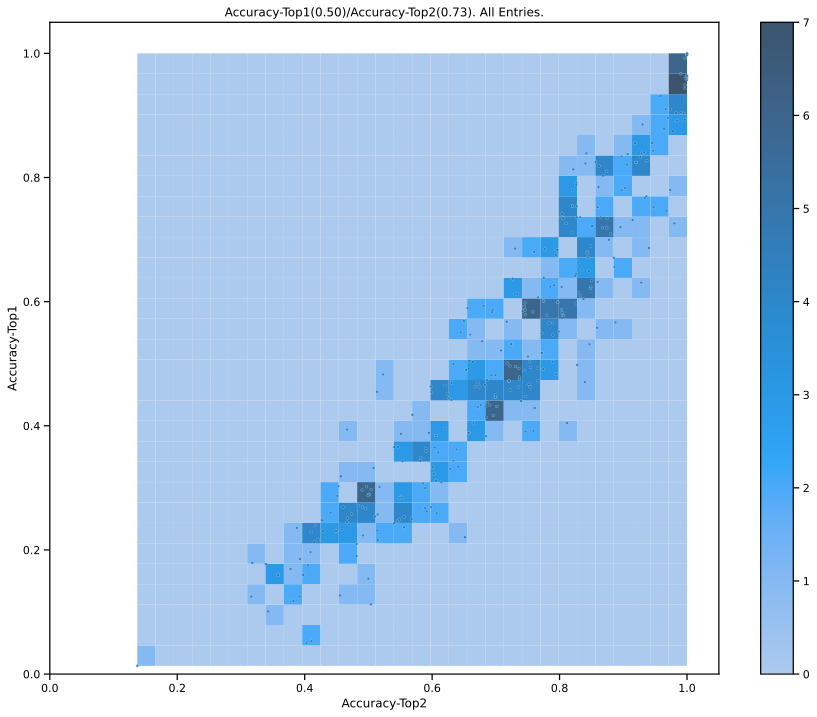

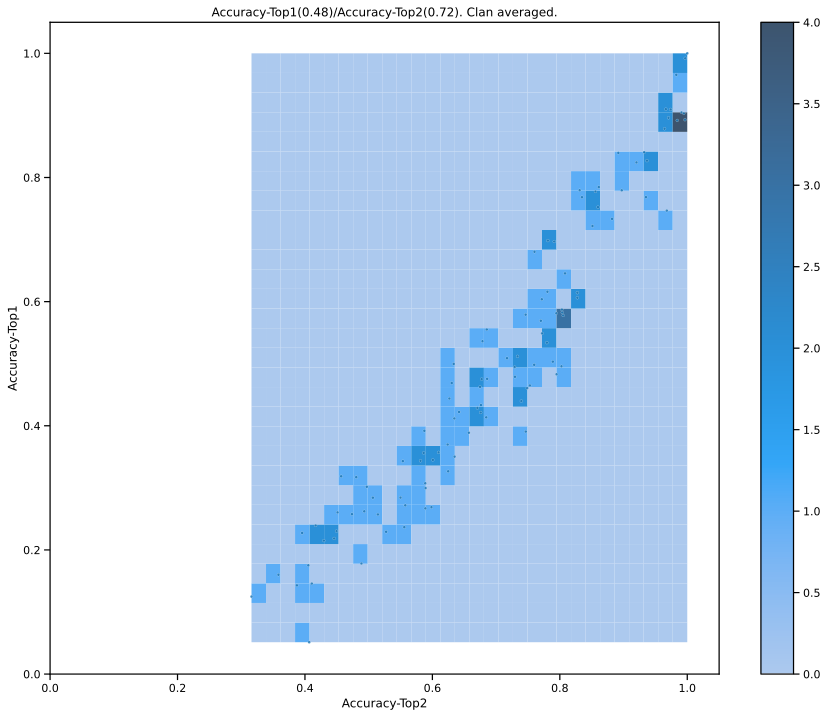

In [3]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
from  NucleicNet.DatasetBuilding import commandBenchmark
from  NucleicNet.Fuel.DS3 import BasicMap
import torchmetrics

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'AUCG'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90







# ==============================
# UNCHANGED
# ===============================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000


CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, User_SequenceHomologyPercent))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])



if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict

"""
if User_Task == "AUCG":
    Df_grand_ = Df_grand_AUCG
else:
    Df_grand_ = Df_grand_SXPR

"""

"""
FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                                DIR_Typi = DIR_Typi,
                                DIR_FuelInput = DIR_FuelInput,
                                Df_grand = Df_grand_,
                                TaskNameLabelLogicDict = None,
                                n_row_maxhold = n_row_maxhold)

TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()
"""

TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()




FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)





with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl

# ========================
# Trained Model
# =========================
from NucleicNet.DatasetBuilding.commandServer import Server
pdbid_done = []
for test_fold in [0,1,2]:

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/48_49/checkpoints/epoch=12-step=42703-hp_metric=0.47925713658332825.ckpt",
                1:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/50_51/checkpoints/epoch=12-step=43961-hp_metric=0.4519999921321869.ckpt",
                2:"../Models/AUCG-9CVMm90_AUCG-9CVMm90/52_53/checkpoints/epoch=12-step=42941-hp_metric=0.4690285623073578.ckpt"
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()


    # =================================
    # Scoring Top1/2 accuracy
    # =================================

    for retrial_i in range(100):
        for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
            with torch.no_grad():
                currentfold = row['3CVCrossFoldIndex']
                if currentfold != test_fold:
                    continue

                genericfn = row['GenericFilename']

                if genericfn in pdbid_done:
                    continue
                currentfold = row['3CVCrossFoldIndex']
                n_class = len(TaskNameLabelLogicDict[User_Task])



                try:
                    # ===================
                    # Retrieve label feature
                    # ======================
                    y = []
                    x = []

                    for i_class in range(n_class):
                        indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
                        if len(indicesretrieve) == 0:
                            continue
                        y.extend([i_class for ii in range(len(indicesretrieve))])
                        # NOTE Retrieval of vectors
                        feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                        x.append(feat)



                    train_x = np.concatenate(x, axis= 0)
                    truey = np.array(y, dtype=np.int32)

                    #sampling_weight = compute_sample_weight(class_weight = None, y = truey)
                    truey = torch.LongTensor(truey)
                    #truey = truey.to('cuda')
                    # =================================
                    # Some tidy up on the Altman feature
                    # =================================
                    train_x = torch.FloatTensor(train_x)
                    train_x /= torch.FloatTensor(IPCA_Std)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    train_x_size = train_x.shape[0]
                    feature_resizeshape  =(6,80)
                    train_x.resize_((train_x_size, *feature_resizeshape)).unsqueeze_(1)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    sign = train_x.sign()
                    train_x.abs_()
                    train_x[train_x <= 1e-6] = 0.0
                    train_x *= sign

                    # NOTE a dummy inserted to prevent cheating!
                    dummy_y = [0 for i in range(train_x.shape[0])]
                    dummy_y = np.array(dummy_y, dtype= int)
                    dummy_yyyy = torch.nn.functional.one_hot(torch.LongTensor(dummy_y).type(torch.int64), num_classes= n_class).type(torch.float32)
                    dummy_y = torch.LongTensor(dummy_y)

                    


                    #train_x = train_x.to("cuda")
                    #dummy_y = dummy_y.to("cuda")
                    #dummy_yyyy = dummy_yyyy.to("cuda")


                    test_loader_t          = torch.utils.data.DataLoader(BasicMap(train_x, dummy_y, dummy_yyyy), 
                                                                        batch_size=1024, 
                                                                        drop_last=False, num_workers=4, 
                                                                        pin_memory=True,worker_init_fn=None, 
                                                                        prefetch_factor=3, persistent_workers=False,
                                                                        shuffle=False)

                    # =================================
                    # Get Prediction
                    # =================================
                    p_list = []                
                    for _, xy in enumerate(test_loader_t):
                        # TODO Get the index in halo and the xyz coordinate of halo here.

                        tempx = xy[0] 
                        tempy = xy[1]
                        tempx = tempx.to('cuda')
                        tempy = tempy.to('cuda')
                        p = model.predict_step((tempx,tempy),0)

                        p_list.append(p)

                        del tempx,tempy
                        gc.collect()


                    p = torch.cat(p_list)
                    p = p.detach().cpu()#.numpy()




                    top1 = torchmetrics.functional.accuracy(p, truey, top_k =1, average = 'weighted', num_classes = n_class).cpu().numpy()
                    top2 = torchmetrics.functional.accuracy(p, truey, top_k =2, average = 'weighted', num_classes = n_class).cpu().numpy()
                    grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
                    grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2

                    #print(top1, top2)



                    pdbid_done.append(genericfn)
                    del p, p_list, train_x, dummy_y, dummy_yyyy, truey
                    NucleicNet.Burn.util.TorchEmptyCache()
                    gc.collect()
                    time.sleep(1)

                except RuntimeError:
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    print("Cuda run out of memory at %s retrial %s or run it later!" %(genericfn, retrial_i))
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #NucleicNet.Burn.util.TorchEmptyCache()




plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()




100%|██████████| 100/100 [4:03:42<00:00, 146.22s/it]


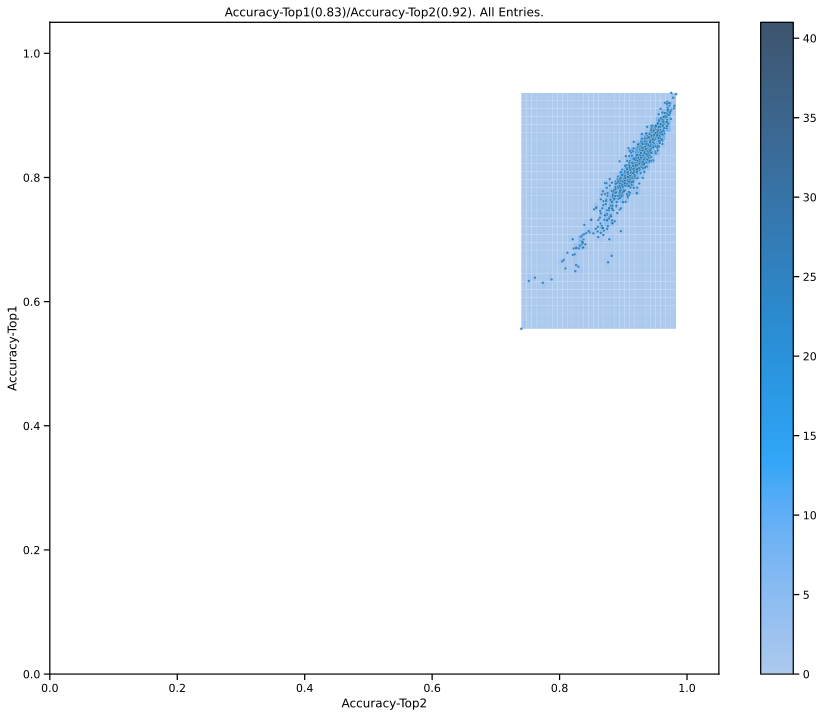

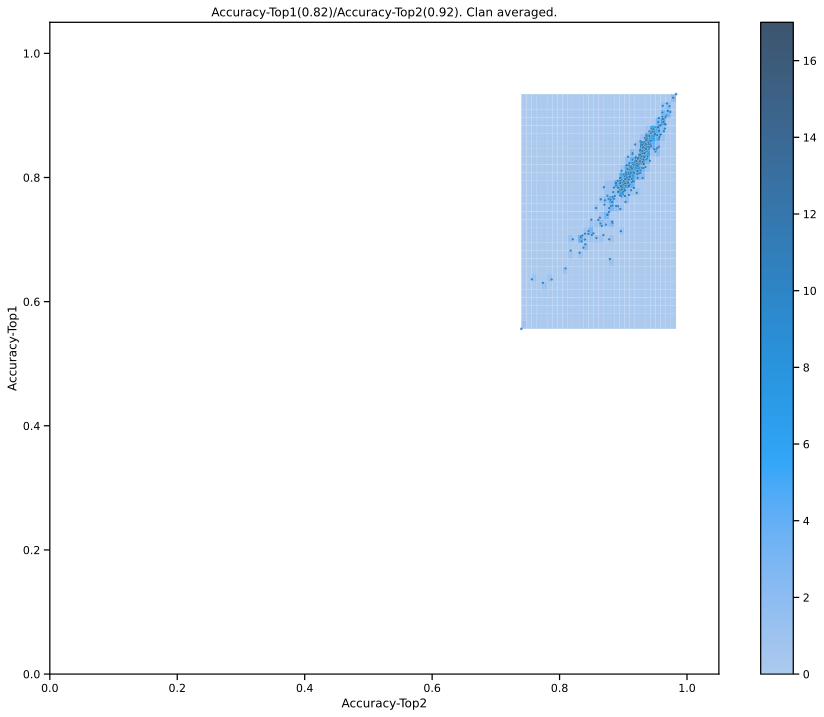

In [3]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
from  NucleicNet.DatasetBuilding import commandBenchmark
from  NucleicNet.Fuel.DS3 import BasicMap
import torchmetrics

# ==================================================
# Indication of task and Sequence Homoology
# =============================================================


User_Task = 'SXPR'
User_ClusterType = "Mmseq"
User_SequenceHomologyPercent = 90







# ==============================
# UNCHANGED
# ===============================
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000


CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, User_SequenceHomologyPercent))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])




if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict

"""
if User_Task == "AUCG":
    Df_grand_ = Df_grand_AUCG
else:
    Df_grand_ = Df_grand_SXPR


"""



"""
FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                                DIR_Typi = DIR_Typi,
                                DIR_FuelInput = DIR_FuelInput,
                                Df_grand = Df_grand_,
                                TaskNameLabelLogicDict = None,
                                n_row_maxhold = n_row_maxhold)

TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()
"""

TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()



FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)





with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl

# ========================
# Trained Model
# =========================
from NucleicNet.DatasetBuilding.commandServer import Server
pdbid_done = []
for test_fold in [0,1,2]:

    # ===============================
    # User insert model here
    # ===============================
    # NOTE User should have trained a model which receive no gradient from ValTest sets
    CorrespondingCheckpointsWhichExcludesValTestData = {
                0:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/6_7/checkpoints/epoch=0-step=21564-hp_metric=0.5079357028007507.ckpt",
                1:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/8_9/checkpoints/epoch=2-step=66455-hp_metric=0.5010985732078552.ckpt",
                2:"../Models/SXPR-9CVMm90_SXPR-9CVMm90/10_11/checkpoints/epoch=2-step=67817-hp_metric=0.5154971480369568.ckpt",
    }
    LoadCkpStateIntoModelC = commandBenchmark.LoadCkpStateIntoModel()
    model, ckp_hyperparam, checkpoint = LoadCkpStateIntoModelC.B1hw_LayerResnetBottleneck(CKPT_PATH =CorrespondingCheckpointsWhichExcludesValTestData[test_fold])
    model.to(torch.device('cuda'))
    model.eval()
                                            
                                            


    # =================================
    # Scoring Top1/2 accuracy
    # =================================

    for retrial_i in tqdm.tqdm(range(100)):
        for row_i , row in CvFoldDf.iterrows():
            with torch.no_grad():
                currentfold = row['3CVCrossFoldIndex']
                if currentfold != test_fold:
                    continue

                genericfn = row['GenericFilename']

                if genericfn in pdbid_done:
                    continue
                currentfold = row['3CVCrossFoldIndex']
                n_class = len(TaskNameLabelLogicDict[User_Task])



                try:
                    # ===================
                    # Retrieve label feature
                    # ======================
                    y = []
                    x = []

                    for i_class in range(n_class):
                        indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
                        if len(indicesretrieve) == 0:
                            continue
                        y.extend([i_class for ii in range(len(indicesretrieve))])
                        # NOTE Retrieval of vectors
                        feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
                        x.append(feat)



                    train_x = np.concatenate(x, axis= 0)
                    truey = np.array(y, dtype=np.int32)

                    #sampling_weight = compute_sample_weight(class_weight = None, y = truey)
                    truey = torch.LongTensor(truey)
                    #truey = truey.to('cuda')
                    # =================================
                    # Some tidy up on the Altman feature
                    # =================================
                    train_x = torch.FloatTensor(train_x)
                    train_x /= torch.FloatTensor(IPCA_Std)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    train_x_size = train_x.shape[0]
                    feature_resizeshape  =(6,80)
                    train_x.resize_((train_x_size, *feature_resizeshape)).unsqueeze_(1)
                    train_x = torch.nan_to_num(train_x, nan = 0.0, posinf = 0.0, neginf = 0.0)
                    sign = train_x.sign()
                    train_x.abs_()
                    train_x[train_x <= 1e-6] = 0.0
                    train_x *= sign

                    # NOTE a dummy inserted to prevent cheating!
                    dummy_y = [0 for i in range(train_x.shape[0])]
                    dummy_y = np.array(dummy_y, dtype= int)
                    dummy_yyyy = torch.nn.functional.one_hot(torch.LongTensor(dummy_y).type(torch.int64), num_classes= n_class).type(torch.float32)
                    dummy_y = torch.LongTensor(dummy_y)

                    


                    #train_x = train_x.to("cuda")
                    #dummy_y = dummy_y.to("cuda")
                    #dummy_yyyy = dummy_yyyy.to("cuda")


                    test_loader_t          = torch.utils.data.DataLoader(BasicMap(train_x, dummy_y, dummy_yyyy), 
                                                                        batch_size=1024, 
                                                                        drop_last=False, num_workers=4, 
                                                                        pin_memory=True,worker_init_fn=None, 
                                                                        prefetch_factor=3, persistent_workers=False,
                                                                        shuffle=False)

                    # =================================
                    # Get Prediction
                    # =================================
                    p_list = []                
                    for _, xy in enumerate(test_loader_t):
                        # TODO Get the index in halo and the xyz coordinate of halo here.

                        tempx = xy[0] 
                        tempy = xy[1]
                        tempx = tempx.to('cuda')
                        tempy = tempy.to('cuda')
                        p = model.predict_step((tempx,tempy),0)

                        p_list.append(p)

                        del tempx,tempy
                        gc.collect()


                    p = torch.cat(p_list)
                    p = p.detach().cpu()#.numpy()




                    top1 = torchmetrics.functional.accuracy(p, truey, top_k =1, average = 'weighted', num_classes = n_class).cpu().numpy()
                    top2 = torchmetrics.functional.accuracy(p, truey, top_k =2, average = 'weighted', num_classes = n_class).cpu().numpy()
                    grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
                    grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2

                    #print(top1, top2)



                    pdbid_done.append(genericfn)
                    del p, p_list, train_x, dummy_y, dummy_yyyy, truey
                    NucleicNet.Burn.util.TorchEmptyCache()
                    gc.collect()
                    time.sleep(1)

                except RuntimeError:
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #print("Cuda run out of memory at %s retrial %s or run it later!" %(genericfn, retrial_i))
                    NucleicNet.Burn.util.TorchEmptyCache()
                    time.sleep(4)
                    #NucleicNet.Burn.util.TorchEmptyCache()




plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()


# Test on an SVM for AUCG Mmseq90

We will use an sklearn implementation of minibatch SVM as an example. The feature will be altman feature or some random vectors. We will use one designated fold of data for validation; the rest for training. 


* A useful util is `FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), pdbid = genericfn, featuretype = "altman", ReturnDense = True)` where the raw altman feature can be retrieved when it has been produced.

In [5]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score
User_Task = 'AUCG'
User_ClusterType = "Mmseq"







# ===== Fixed
DIR_DerivedData = "../Database-PDB/DerivedData/"
DIR_Typi = "../Database-PDB/typi/"
DIR_FuelInput = "../Database-PDB/feature/"

n_CrossFold = 9
User_featuretype = 'altman'
n_row_maxhold = 10000

CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, 90))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])










if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict

"""
if User_Task == "AUCG":
    Df_grand_ = Df_grand_AUCG
else:
    Df_grand_ = Df_grand_SXPR
"""


"""
FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                                DIR_Typi = DIR_Typi,
                                DIR_FuelInput = DIR_FuelInput,
                                Df_grand = Df_grand_,
                                TaskNameLabelLogicDict = None,
                                n_row_maxhold = n_row_maxhold)

TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()
"""

TaskNameLabelLogicDict = TEMPLATE_TaskNameLabelLogicDict()



FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)



with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl



for test_fold in [0,1,2,]:

    # ===============================
    # User insert model here
    # ===============================
    SGDClassifierC = linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                            alpha=0.0001, l1_ratio=0.15, fit_intercept=True,  shuffle=False, verbose=0, 
                                            epsilon=0.1, n_jobs=1, random_state=None, learning_rate='optimal', 
                                            eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)

    # ================================
    # Training
    # ================================
    
    traindf = CvFoldDf.loc[CvFoldDf['3CVCrossFoldIndex'] != test_fold]
    #jj = 0
    for row_i , row in tqdm.tqdm(traindf.iterrows()):
        #if jj > 20:
        #    continue
        # NOTE Training 
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])
        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])

            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)


            #sys.exit()
        x = np.concatenate(x, axis= 0)
        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)

        # NOTE Incremental SVM
        SGDClassifierC.partial_fit(x,y, classes =list(range(n_class)), sample_weight= sampling_weight) 
        #jj +=1



    # =================================
    # Scoring Top1/2 accuracy
    # =================================
    #jj = 0
    for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
        currentfold = row['3CVCrossFoldIndex']
        if currentfold != test_fold:
            continue
        #if jj > 20:
        #    continue
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])

        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])
            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)

        x = np.concatenate(x, axis= 0)
        x /= IPCA_Std.flatten()
        x = np.nan_to_num(x, nan = 0.0, posinf = 0.0, neginf = 0.0)

        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)


        y_pred = SGDClassifierC.predict(x)
        ypred_onehot = np.zeros((y.shape[0], n_class), dtype =np.int32)
        ypred_onehot[np.arange(y_pred.shape[0]), y_pred] = 1

        # NOTE Top accuracys
        top1 = top_k_accuracy_score(y, ypred_onehot, k=1, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        top2 = top_k_accuracy_score(y, ypred_onehot, k=2, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
        grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2
        #print(top1,top2)
        #print(score) # NOTE which accuracy is it?

        #jj +=1
    del SGDClassifierC
    gc.collect()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()



38it [01:19,  4.56s/it]

# SVM on SXPR Mmseq90 

The SVM performance on SXPR is particularly poor below. I would attribute this to the extreme class imbalance - even though a sampling weight is assigned, the vast variation of the non-site were not learned. Note that remember when we train the Resnet the feed in for non-site is deliberately reduced to one-tenth. Check.

541it [32:15,  3.58s/it]
857it [14:36,  1.02s/it]
600it [32:54,  3.29s/it]
857it [13:51,  1.03it/s]
573it [29:41,  3.11s/it]
857it [16:00,  1.12s/it]


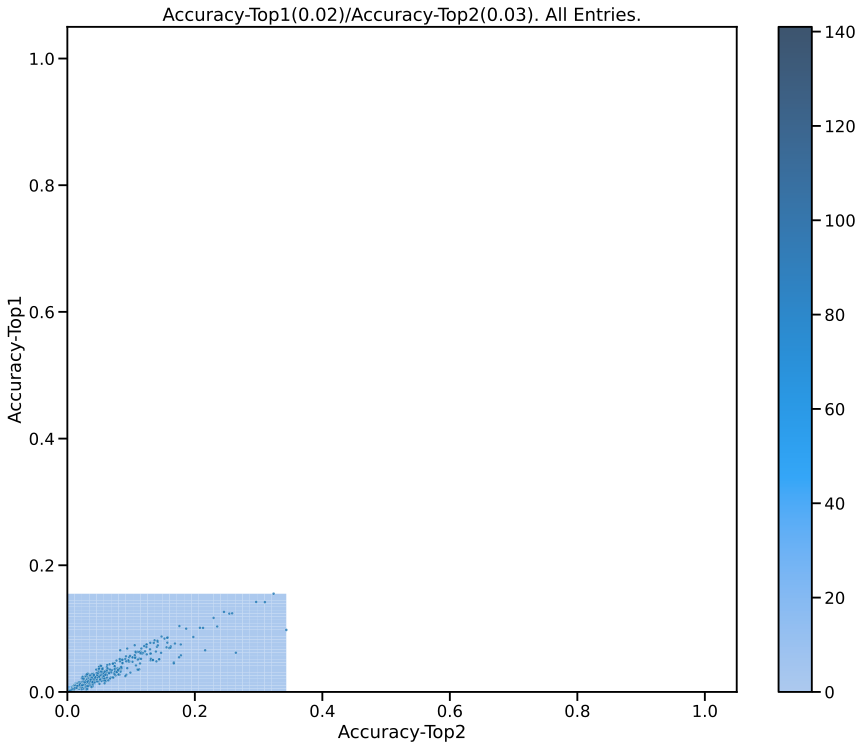

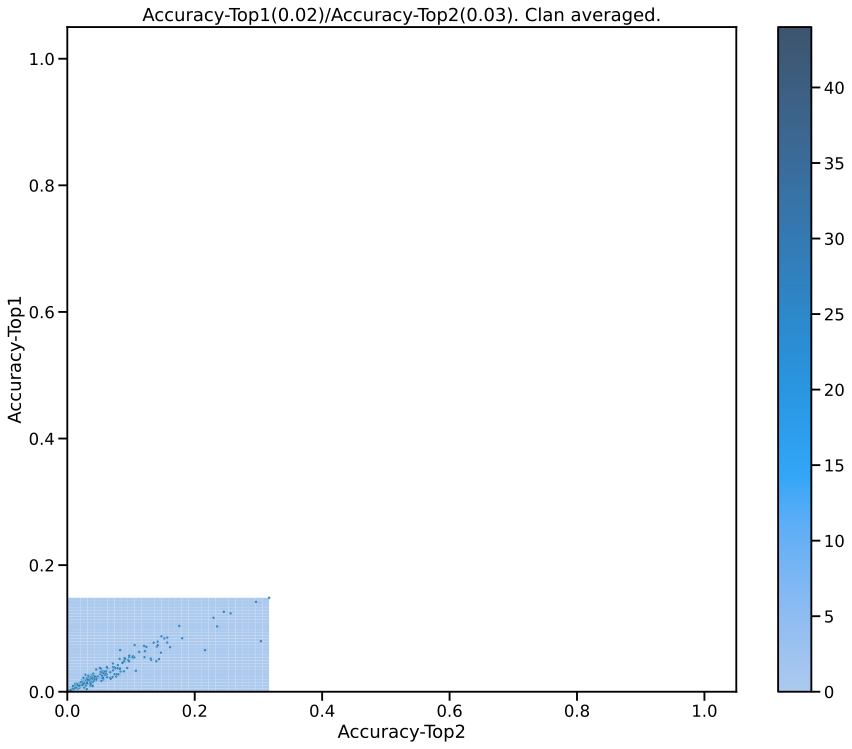

In [23]:
import numpy as np
from sklearn import linear_model
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import top_k_accuracy_score


User_Task = 'SXPR'

CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, "Mmseq", 90))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])



User_ClusterType = "Mmseq"
CvFoldDf = pd.read_pickle(DIR_DerivedData + "/3CvFoldReference_%s_%s_%s.pkl" %(User_Task, User_ClusterType, 90))
grandbenchmark_df  =CvFoldDf.drop(columns=["Class_HaloIndex_%s" %(i_class) for i_class in range(4)])



if User_ClusterType == "Mmseq":
    from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict
else:
    from NucleicNet.DatasetBuilding.commandDataFetcher import FetchIndex, FetchTask, FetchDataset, TEMPLATE_TaskNameLabelLogicDict

if User_Task == "AUCG":
    Df_grand_ = Df_grand_AUCG
else:
    Df_grand_ = Df_grand_SXPR




FetchTaskC = FetchTask(DIR_DerivedData = DIR_DerivedData,
                                DIR_Typi = DIR_Typi,
                                DIR_FuelInput = DIR_FuelInput,
                                Df_grand = Df_grand_,
                                TaskNameLabelLogicDict = None,
                                n_row_maxhold = n_row_maxhold)

TaskNameLabelLogicDict = FetchTaskC.Return_TaskNameLabelLogicDict()




FetchIndexC = FetchIndex(DIR_Feature = DIR_FuelInput, 
                        DIR_Typi =  DIR_Typi, n_row_maxhold =  n_row_maxhold)



with open(DIR_DerivedData + "Feature.IPCA.altman.AUCG.pkl", "rb") as fn: 
    IPCA = pickle.load(fn)
IPCA_Std = (IPCA.var_)**0.5 # NOTE The statistics are caclaulted from AUCG (we avoided collecting it from all datapoints as it was swamped with nonsites), but can be applied to any dataset. There is no Feature.IPCA.altman.SXPR.pkl




for test_fold in [0,1,2,]:

    # ===============================
    # User insert model here
    # ===============================
    SGDClassifierC = linear_model.SGDClassifier(loss='hinge', penalty='l2', 
                                            alpha=0.0001, l1_ratio=0.15, fit_intercept=True,  shuffle=False, verbose=0, 
                                            epsilon=0.1, n_jobs=1, random_state=None, learning_rate='optimal', 
                                            eta0=0.0, power_t=0.5, class_weight=None, warm_start=False)

    # ================================
    # Training
    # ================================
    traindf = CvFoldDf.loc[CvFoldDf['3CVCrossFoldIndex'] != test_fold]
    #jj = 0
    for row_i , row in tqdm.tqdm(traindf.iterrows()):
        #if jj > 20:
        #    continue
        # NOTE Training 
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])
        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])

            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                                    pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)


            #sys.exit()
        x = np.concatenate(x, axis= 0)
        # TODO Insert the std here


        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)

        # NOTE Incremental SVM
        SGDClassifierC.partial_fit(x,y, classes =list(range(n_class)), sample_weight= sampling_weight) 
        #jj +=1



    # =================================
    # Scoring Top1/2 accuracy
    # =================================
    #jj = 0
    for row_i , row in tqdm.tqdm(CvFoldDf.iterrows()):
        currentfold = row['3CVCrossFoldIndex']
        if currentfold != test_fold:
            continue
        #if jj > 20:
        #    continue
        genericfn = row['GenericFilename']
        currentfold = row['3CVCrossFoldIndex']
        n_class = len(TaskNameLabelLogicDict[User_Task])

        # ===================
        # Retrieve label feature
        # ======================
        y = []
        x = []
        for i_class in range(n_class):
            indicesretrieve = row["Class_HaloIndex_%s" %(i_class)]
            if len(indicesretrieve) == 0:
                continue
            y.extend([i_class for ii in range(len(indicesretrieve))])
            # NOTE Retrieval of vectors
            feat = FetchIndexC.UTIL_Index_Feature(np.array(indicesretrieve, dtype=np.int32), 
                                        pdbid = genericfn, featuretype = "altman", ReturnDense = True)
            x.append(feat)

        x = np.concatenate(x, axis= 0)
        y = np.array(y, dtype=np.int32)
        sampling_weight = compute_sample_weight(class_weight = None, y = y)


        y_pred = SGDClassifierC.predict(x)
        ypred_onehot = np.zeros((y.shape[0], n_class), dtype =np.int32)
        ypred_onehot[np.arange(y_pred.shape[0]), y_pred] = 1

        # NOTE Top accuracys
        top1 = top_k_accuracy_score(y, ypred_onehot, k=1, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        top2 = top_k_accuracy_score(y, ypred_onehot, k=2, normalize=True, sample_weight=sampling_weight, labels=list(range(n_class)))
        grandbenchmark_df.loc[row_i, "Accuracy-Top1"] = top1
        grandbenchmark_df.loc[row_i, "Accuracy-Top2"] = top2
        #print(top1,top2)
        #print(score) # NOTE which accuracy is it?

        #jj +=1
    del SGDClassifierC
    gc.collect()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). All Entries." %(grandbenchmark_df["Accuracy-Top1"].median(),grandbenchmark_df["Accuracy-Top2"].median() ))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

# ===================
# Clan averaged
# ==================

grandbenchmark_df_ClanGrouped = grandbenchmark_df.groupby(by=["SequenceHomology_Clan"] ).agg('mean').reset_index()


plt.figure(figsize = (15,12))
g = sns.histplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", kde=False, bins = 30, palette='YlGnBu', thresh = None, cbar = True)
sns.scatterplot(data=grandbenchmark_df_ClanGrouped, y="Accuracy-Top1", x="Accuracy-Top2", 
                marker = 'o', s = 8.0, palette='husl', alpha = 0.8)

plt.title("Accuracy-Top1(%.2f)/Accuracy-Top2(%.2f). Clan averaged." %(grandbenchmark_df_ClanGrouped["Accuracy-Top1"].median(),grandbenchmark_df_ClanGrouped["Accuracy-Top2"].median()))
plt.xlim((0,1.05))
plt.ylim((0,1.05))
plt.show()

In [ ]:


# TODO Test the use of index by pairing to feature. incremental learning with Naive bayes https://scikit-learn.org/0.15/modules/scaling_strategies.html
# https://scikit-learn.org/0.15/modules/scaling_strategies.html

# TODO Double check this with out own model (X to Y mapping)



In [ ]:

# ============== Click Please.Imports
import sys
import glob
import gc


import random
random.seed(0)
import pandas as pd

import torch
import seaborn as sns

import matplotlib.pyplot as plt



import tqdm



# ================
# Torch related
# ==============
import torch 
from torch import nn



import pytorch_lightning as pl
import torchmetrics

# Turn on cuda optimizer
print(torch.backends.cudnn.is_available())
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
# disable debugs NOTE use only after debugging
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)
# Disable gradient tracking
torch.no_grad()


# =============
# NN
# =================
sys.path.append('../')
from NucleicNet.DatasetBuilding.util import *
from NucleicNet.DatasetBuilding.commandDataFetcherMmseq import FetchIndex, FetchTask, FetchDataset # NOTE Mmseq
from NucleicNet.DatasetBuilding.commandBenchmarkMmseq import BenchmarkWrapper
import NucleicNet.Burn.util





%config InlineBackend.figure_format = 'svg'

sns.set_context("notebook")





## ==========================================================================================
## :x: WARNING. DO NOT RUN AFTER THIS LINE UNLESS YOU WANT TO OVERWRITE THE CHECKSUM STORED.
## ===========================================================================================

# Number of Datapoints

# Checksum Typi

# Checksum Halo


# Checksum Feature

# Checksum Landmarks

# Checksum Cleansed

# Checksum Apo